# core

> Fill in a module description here

In [ ]:
#| default_exp core

In [ ]:
#| export
import base64
import tiktoken
import base64
import io
import json
import matplotlib.pyplot as plt
import numpy as np
import os
from pdf2image import convert_from_path
import PyPDF2
import requests
import shutil
from fastcore.all import *

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
def split_pdf(file_path, every=1, until=None, output_folder=None):
    """
    Split a PDF file into multiple smaller PDF files.

    Args:
        file_path (str): The path to the input PDF file.
        every (int, optional): The interval at which to split the PDF. Default is 1.
        until (int, optional): The page number until which to split the PDF. Default is None.
        output_folder (str, optional): The folder where the split PDF files will be saved. Default is None.

    Returns:
        int: The number of splits performed.

    """
    pdf_file = PyPDF2.PdfFileReader(file_path)
    total_pages = pdf_file.getNumPages()
    if until is None:
        until = total_pages
    
    if output_folder is None:
        output_folder = os.path.dirname(file_path)
    else:
        if not os.path.exists(output_folder):
            os.makedirs(output_folder)
    
    basename = os.path.splitext(os.path.basename(file_path))[0]
    
    pdf_writer = PyPDF2.PdfFileWriter()
    num_splits = 0
    
    for page in range(total_pages):
        pdf_writer.addPage(pdf_file.getPage(page))
        
        if (page + 1) % every == 0 or page + 1 == until:
            output_file = f"{output_folder}/{basename}_page_{page + 1}.pdf"
            with open(output_file, "wb") as out:
                pdf_writer.write(out)
            pdf_writer = PyPDF2.PdfFileWriter()
            num_splits += 1
    
    # Write remaining pages if any
    if pdf_writer.getNumPages() > 0:
        output_file = f"{output_folder}/{basename}_page_{page + 1}.pdf"
        with open(output_file, "wb") as out:
            pdf_writer.write(out)
        num_splits += 1
    
    return num_splits

In [ ]:
path = '../example_data/1.pdf'
output_folder='../example_data/split'
foo = split_pdf(path, 1, output_folder=output_folder)
test_eq(foo, 2)
# remove output folder
shutil.rmtree(output_folder)

In [ ]:
#| export
def encode_image(image_path):
  """Function to encode the image"""
  with open(image_path, "rb") as image_file:
    return base64.b64encode(image_file.read()).decode('utf-8')

In [ ]:
image_path = '../example_data/1.jpg'
image_base64 = encode_image(image_path)
test_eq_type(type(image_base64), str)

In [ ]:
#| export
def num_tokens_from_messages(messages, model="gpt-3.5-turbo-0613"):
  """Returns the number of tokens used by a list of messages."""
  try:
      encoding = tiktoken.encoding_for_model(model)
  except KeyError:
      encoding = tiktoken.get_encoding("cl100k_base")
  if model == "gpt-3.5-turbo-0613":  # note: future models may deviate from this
      num_tokens = 0
      for message in messages:
          num_tokens += 4  # every message follows <im_start>{role/name}\n{content}<im_end>\n
          for key, value in message.items():
              num_tokens += len(encoding.encode(value))
              if key == "name":  # if there's a name, the role is omitted
                  num_tokens += -1  # role is always required and always 1 token
      num_tokens += 2  # every reply is primed with <im_start>assistant
      return num_tokens
  else:
      raise NotImplementedError(f"""num_tokens_from_messages() is not presently implemented for model {model}.""")

In [ ]:
image_path = '../example_data/1.jpg'
base64_image = encode_image(image_path)
messages = [{"role": "user", "content": "Hello, how are you?", "image": base64_image}]
num_tokens = num_tokens_from_messages(messages)
num_tokens


351620

In [ ]:
#| export
DEFAULT_SYSTEM_PROMPT = ("You are a helpful assistant designed to see an exam and output JSON \
with the extracted information. You will be given an image of the exam.")

DEFAULT_USER_PROMPT = ("Extract the last name (Apellidos in Spanish) and the first name \
(Nombre in Spanish) from the top of the image, and turn them into upper case. \
You will find them handwritten after the labels `Apellidos` and `Nombre` respectively. \
The fields of your JSON output will have those exact same label names")

In [ ]:
#| export
def extract_student_info(path_pdf: str, crop=None, api_key = None, 
                 model="gpt-4o", prompt=DEFAULT_USER_PROMPT, 
                 system_prompt=DEFAULT_SYSTEM_PROMPT, page_number=1, max_tokens=3000,
                 verbose=False):
    """
    Extracts student information from a PDF file using OpenAI's chatGPT.

    Args:
        path_pdf (str): The path to the PDF file.
        crop (tuple, optional): Tuple with the coordinates of the crop (left, top, right, bottom).
        api_key (str, optional): The API key for accessing the OpenAI API. If 
            not provided, the function will try to use the OPENAI_API_KEY environment variable.
        model (str, optional): The model to use for generating responses.
        prompt (str, optional): The user prompt to start the conversation.
        system_prompt (str, optional): The system prompt to provide context to the model.
        page_number (int, optional): The page number of the PDF to extract the information from.
        max_tokens (int, optional): The maximum number of tokens to use for the response.
        verbose (bool, optional): Whether to print information about the process.

    Returns:
        str: The extracted information from the PDF.

    Raises:
        KeyError: If the OPENAI_API_KEY environment variable is not set.
        IndexError: If the response from the OpenAI API does not contain any choices.

    """
    with open(path_pdf, 'rb') as file:
        # Convert the PDF to images and get one of them
        image = convert_from_path(path_pdf, fmt='jpeg')[page_number - 1]

        # Crop the image
        if crop:
            image = image.crop(crop)
        
        if verbose:
            plt.imshow(np.array(image))
            plt.axis('off')  # Ocultar los ejes
            plt.show()
        
        # Convert to base64
        buffered = io.BytesIO()
        image.save(buffered, format="JPEG")
        base64_image = base64.b64encode(buffered.getvalue()).decode('utf-8')

        headers = {
            "Content-Type": "application/json",
            "Authorization": f"Bearer {ifnone(api_key, os.environ.get('OPENAI_API_KEY'))}"
        }
        payload = {
            "model": f'{model}',
            "response_format": { "type": "json_object" },
            "messages": [
                {
                    "role": "system", 
                    "content": f"{system_prompt}",   
                },
                {
                    "role": "user",
                    "content": [
                        {
                            "type": "text",
                            "text": f"{prompt}"
                        },
                        {
                            "type": "image_url",
                            "image_url": {
                                "url": f"data:image/jpeg;base64,{base64_image}"
                            }
                        }
                    ]
                }
            ],
            "max_tokens": max_tokens
        }
        response = requests.post("https://api.openai.com/v1/chat/completions", 
                                 headers=headers, json=payload)
        res = json.loads(response.json()['choices'][0]['message']['content'])
        if verbose:
            print(res)
        
        return res 

In [ ]:
#| eval: false
path_pdf = '../example_data/1.pdf'
info = extract_student_info(path_pdf)
info

{'Apellidos': 'RODRIGUEZ FERNANDEZ', 'Nombre': 'VICTOR'}

In [ ]:
#| export
@delegates(extract_student_info)
def rename_exam_file(pdf_path: str, output_folder=None, keep_old=True, **kwargs):
    """
    Extracts student information from an exam PDF file using OpenAI's chatGPT and renames that
    file with the extracted information as the name.

    Parameters:
    - pdf_path (str): The path to the input PDF file.
    - output_folder (str): The path to the directory where the renamed file will be saved. 
    If not provided, the file will be saved in the same directory as the input file.
    - keep_old (bool): Whether to keep the old file or not.
    - **kwargs: Additional keyword arguments to be passed to the `extract_student_info` function.

    Returns:
    - new_name (str): The new name of the renamed file.

    Example:
    >>> rename_exam_file('/path/to/input.pdf', '/path/to/output', option1='value1', option2='value2')
    'Doe_John'
    """
    info = extract_student_info(pdf_path, **kwargs)
    new_name = f"{info['Apellidos']}_{info['Nombre']}"
    new_file_path = os.path.join(output_folder, new_name, ".pdf")
    if not keep_old:
        os.rename(pdf_path, new_file_path)
    else:
        os.makedirs(output_folder, exist_ok=True)
        if not os.path.exists(new_file_path):
            shutil.copy(pdf_path, new_file_path)
        
    return new_name

In [ ]:
#| eval: false
path_pdf = '../example_data/1.pdf'
output_path = '../example_data'
new_name = rename_exam_file(pdf_path=path_pdf, output_path=output_path, keep_old=False)
new_name

'RODRIGUEZ FERNANDEZ_VICTOR.pdf'

In [ ]:
#| export
@delegates(rename_exam_file)
def rename_all_exam_files(input_folder: str, **kwargs):
    """
    Renames all the exam PDF files in a folder with the extracted student information.

    Parameters:
    - input_folder (str): The path to the folder containing the input PDF files.
    - **kwargs: Additional keyword arguments to be passed to the `rename_exam_file` function.

    Returns:
    - new_names (list): A list of the new names of the renamed files.

    Example:
    >>> rename_all_exam_files('/path/to/folder', option1='value1', option2='value2')
    ['Doe_John.pdf', 'Smith_Alice.pdf']
    """
    pdf_files = [f for f in os.listdir(input_folder) if f.endswith('.pdf')]
    new_names = []
    for pdf_file in pdf_files:
        pdf_path = os.path.join(input_folder, pdf_file)
        new_name = rename_exam_file(pdf_path, output_folder=input_folder, **kwargs)
        new_names.append(new_name)
    return new_names

In [ ]:
#| eval: false
path_folder = '../example_data'
new_names = rename_all_exam_files(input_folder=path_folder)
# Check that the file was renamed and a new file was created
test_eq(new_names, ['RODRIGUEZ FERNANDEZ_VICTOR.pdf'])
test_eq(os.path.exists(os.path.join(path_folder, 'RODRIGUEZ FERNANDEZ_VICTOR.pdf')), True)

In [ ]:
#| export
@delegates(extract_student_info)
def prompt_ocr(path: str, **kwargs):
    """  """
    if os.path.isfile(path):
        file_paths = [path]
    else:
        file_paths = [os.path.join(path, f) for f in os.listdir(path) if f.endswith('.pdf')]
    res =[]
    for fp in file_paths:
        info = extract_student_info(fp, **kwargs)
        info['file_name'] = fp
        res.append(info)
    return res

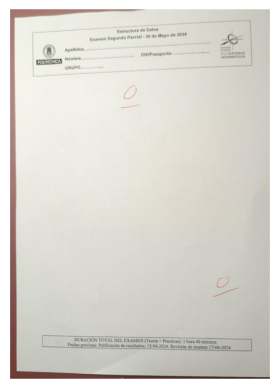

{'grade': 0}


[{'grade': 0, 'file_name': '../example_data/1.pdf'}]

In [ ]:
#| eval: false
path_folder = '../example_data'
with open('../example_data/user_prompt_grade.md', 'r') as f:
    prompt = f.read()
info = prompt_ocr(path_folder, prompt=prompt, page_number=2, verbose=True)
info

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()